In [2]:
import tensorflow as tf
# suppress warnings for cleaner output
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import Model, Sequential
import keras.layers as layers
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D, Input, Lambda
from keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3, preprocess_input
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.applications import ResNet50V2
from keras.applications.mobilenet import MobileNet
from keras.applications.xception import Xception

from glob import glob
import os
import cv2
import random
import numpy as np
import shutil
from sklearn.metrics import confusion_matrix
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

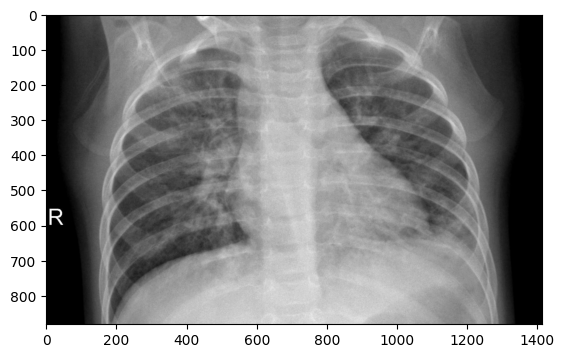

In [5]:
file = 'Dataset/train/opacity/person99_virus_183.jpeg'
# from google.colab.patches import cv2_imshow

# cv2_imshow(cv2.imread())
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(file)
imgplot = plt.imshow(img, cmap='gray')
plt.show()

In [6]:
img.shape

(882, 1414)

In [7]:
def check_gpu():
  if tf.test.gpu_device_name() != '':
    print("GPU sucessfully connected")


In [8]:
#Setup and check a gpu connection.
''' Do not change this cell '''
check_gpu()

In [9]:
import os

target_dir = 'Dataset'
file_count = sum(len(files) for _, _, files in os.walk(target_dir))
print(file_count)

5856


In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import random
from PIL import Image

# Define the path to your dataset
base_dir = "Dataset"

# Function to create dataframe from a given directory
def create_dataframe(base_dir, subset):
    categories = ['normal', 'opacity']
    data = []

    for category in categories:
        class_dir = os.path.join(base_dir, subset, category)
        for img_path in glob(os.path.join(class_dir, "*.jpeg")):
            img_path = os.path.normpath(img_path)
            if 'bacteria' in img_path:
                label = 'Pneumonia' # 'bacterial pneumonia'
            elif 'virus' in img_path:
                label = 'Pneumonia' #'viral pneumonia'
            else:
                label = 'Normal'
            data.append((img_path, label))

    df = pd.DataFrame(data, columns=['image_path', 'label'])
    return df

# Create dataframes for train, val, and test
train_df = create_dataframe(base_dir, 'train')
val_df = create_dataframe(base_dir, 'val')
test_df = create_dataframe(base_dir, 'test')

print(f'train_df.shape: {train_df.shape}')
print(f'val_df.shape:{val_df.shape}')
print(f'test_df.shape:{test_df.shape}')



train_df.shape: (4192, 2)
val_df.shape:(1040, 2)
test_df.shape:(624, 2)


In [11]:
train_df.head()

image_path   label
0  Dataset\train\normal\IM-0115-0001.jpeg  Normal
1  Dataset\train\normal\IM-0117-0001.jpeg  Normal
2  Dataset\train\normal\IM-0119-0001.jpeg  Normal
3  Dataset\train\normal\IM-0122-0001.jpeg  Normal
4  Dataset\train\normal\IM-0125-0001.jpeg  Normal

### Training pipeline functions

In [12]:
def get_image_generators(preprocess_func, target_size=(224,224), class_mode='binary'):
        # Train generator
    train_datagen = ImageDataGenerator(
        # rescale=1./255,
        preprocessing_function=preprocess_func, # tf.keras.applications.vgg16.preprocess_input,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.8, 1.1),
        zoom_range=0.1,
        fill_mode="constant"   ###"reflect" or "wrap"
        )
    # Generate batches of data from the train data directory
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col="image_path",
        y_col="label",
        target_size=target_size,
        batch_size=32,
        class_mode=class_mode,
        color_mode='rgb',
        shuffle=True,
    )

    # Validation Generator
    val_datagen = ImageDataGenerator(
        # rescale=1./255,
        preprocessing_function=preprocess_func
        )

    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        x_col="image_path",
        y_col="label",
        target_size=target_size,
        batch_size=32,
        class_mode=class_mode,
        color_mode='rgb',
        shuffle=False
    )

    # Test generator
    test_datagen = ImageDataGenerator(
        # rescale=1./255,
        preprocessing_function=preprocess_func)
    # Generate batches of data from the test data directory
    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col="image_path",
        y_col="label",           ## None or "label" ?
        target_size=target_size,
        batch_size=32,
        class_mode=class_mode,
        color_mode='rgb',
        shuffle=False  # Set to False to maintain order for evaluation
    )

    return train_generator, val_generator, test_generator


def plot_aug_images(generator, title, n=5):
    fig, ax = plt.subplots(nrows=1, ncols=n, figsize=(20, 3))
    fig.suptitle(title)

    for i in range(n):
        # Get a batch of images and labels from the generator
        batch = next(generator)
        images = batch[0]
        labels_batch = batch[1]

        # Pick one image from the batch
        image = images[i]

        # Rescale the image to the original range [0, 255]
        image = (image * 255).astype('uint8')

        label = labels_batch[i]

        # Plot raw pixel data
        ax[i].imshow(image)
        #ax[i].axis('off')
        # if np.array_equal(label, [0]):
        #     title = 'bacterial pneumonia'
        # elif np.array_equal(label, [0, 1, 0]):
        #     title = 'normal'
        # elif np.array_equal(label, [0, 0, 1]):
        #     title = 'viral pneumonia'
        # else:
        #     title = 'Unknown'
        title = 'Normal' if label == 0. else 'Pneumonia'
        # title = 'Normal' if np.array_equal(label, [0, 1]) else 'Pneumonia'
        ax[i].set_title(title)

    plt.show()

In [13]:
# Model training and eval
def train_model(model, train_generator, val_generator, model_filename):
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
    '''sparse_categorical_crossentropy is for integer targets;
        categorical_crossentropy is for one hot encoded targets;
        binary_crossentropy is for integer binary targets'''

    # Define callbacks
    checkpoint = ModelCheckpoint(model_filename, save_best_only=True, monitor='val_loss', mode='min')
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
    early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

    # Train the model
    history = model.fit(
        train_generator,
        epochs=100,
        validation_data=val_generator,
        callbacks=[checkpoint, early_stopping, lr_scheduler]
    )

    return history

def plot_curves(history, title=None):
    metrics = list(history.history.keys())
    num_metrics = len(metrics) // 2
    metrics = metrics[:num_metrics]
    print(metrics)
    rows = (num_metrics + 2) // 3  # Calculate the number of rows needed for subplots

    plt.figure(figsize=(16, rows*3))
    plt.title(title)
    plt.axis('off')
    # Train Loss vs Validation Loss
    for i in range(num_metrics):
        plt.subplot(rows, 3, i+1)
        metric_name = metrics[i].split("_")[0].capitalize()
        plt.plot(history.history[metrics[i]], label=f'Train {metric_name}')
        plt.plot(history.history[f'val_{metrics[i]}'], label=F'Validation {metric_name}')
        plt.xlabel('Epoch')
        plt.ylabel(f'{metric_name}')
        plt.legend()

    plt.tight_layout()
    plt.show()


def get_evaluation_report(model, test_generator):
    pred = model.predict(test_generator)
    pred = [0 if p < 0.5 else 1 for p in pred]

    sns.heatmap(confusion_matrix(test_generator.labels, pred), annot=True, fmt='d')

    # Generate classification report
    report = classification_report(test_generator.labels, pred, target_names=['Normal', 'Pneumonia'])

    print("__Classification Report__ :")
    print(report)

    

## Custom model

In [14]:
plt.imread(train_df.image_path[0]).shape

(1858, 2090)

In [13]:

def preprocess_image(image):
    # Convert the image to a NumPy array
    img_array = np.array(image)

    # Resize the image to the target size first
    img_array = cv2.resize(img_array, (224, 224))

    # Convert to grayscale
    img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)

    # Ensure the image is in uint8 format
    if img_array.dtype != np.uint8:
        img_array = img_array.astype(np.uint8)

    # Perform histogram equalization
    img_array = cv2.equalizeHist(img_array)

    # Apply Gaussian blurring
    img_array = cv2.GaussianBlur(img_array, (5, 5), 0)

    # Expand dimensions to have a single channel
    img_array = np.expand_dims(img_array, axis=-1)

    # # Rescale the image
    # img_array = img_array / 255.0

    # Convert the image to float32 and rescale it
    img_array = img_array.astype(np.float32) / 255.0

    return img_array


Found 4192 validated image filenames belonging to 2 classes.
Found 1040 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


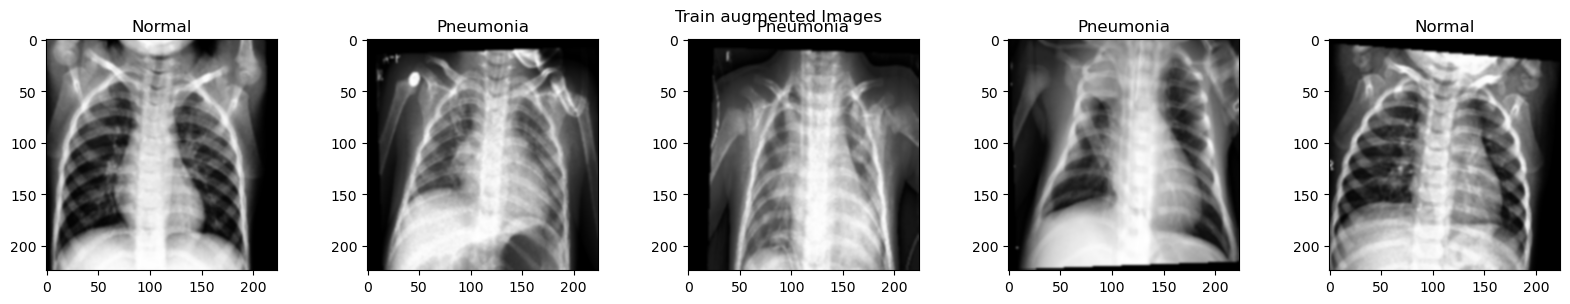

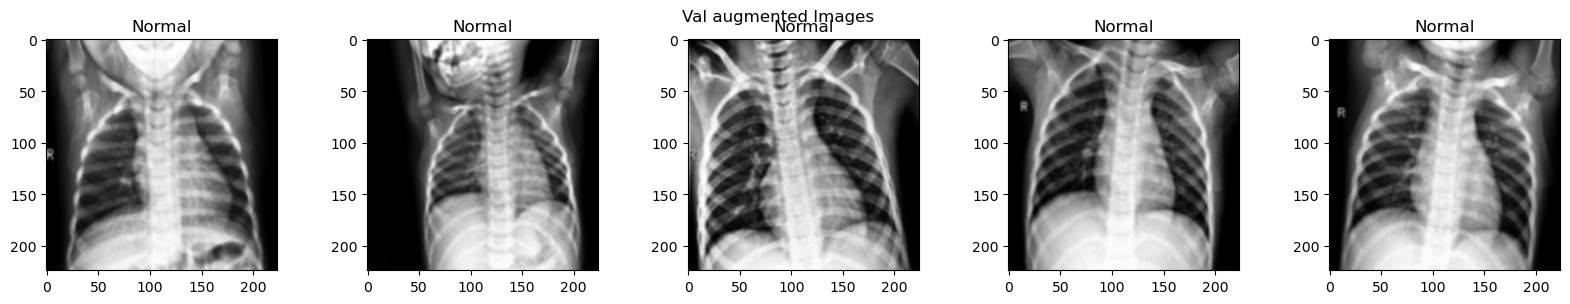

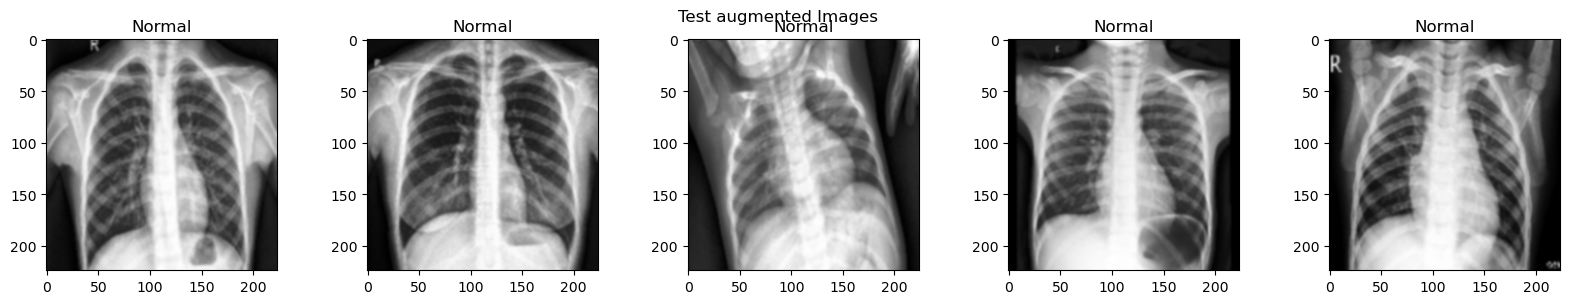

In [62]:
train_generator, val_generator, test_generator = get_image_generators(preprocess_image)

# Reset the generators to avoid issues with plotting
train_generator.reset()
val_generator.reset()
test_generator.reset()

# Plot 5 augmented train images
plot_aug_images(train_generator, "Train augmented Images")
plot_aug_images(val_generator, "Val augmented Images")
plot_aug_images(test_generator, "Test augmented Images")

In [25]:

model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])



In [26]:
history = train_model(model, train_generator, val_generator, './models/custom_model.keras')

Epoch 1/100
131/131 [==============================] - 90s 666ms/step - loss: 0.4365 - accuracy: 0.8266 - precision_1: 0.9288 - recall_1: 0.8299 - auc_1: 0.9041 - val_loss: 7.0889 - val_accuracy: 0.7433 - val_precision_1: 0.7433 - val_recall_1: 1.0000 - val_auc_1: 0.5000 - lr: 0.0010
Epoch 2/100
131/131 [==============================] - 86s 655ms/step - loss: 0.2593 - accuracy: 0.9048 - precision_1: 0.9391 - recall_1: 0.9322 - auc_1: 0.9522 - val_loss: 2.1871 - val_accuracy: 0.7433 - val_precision_1: 0.7433 - val_recall_1: 1.0000 - val_auc_1: 0.5000 - lr: 0.0010
Epoch 3/100
131/131 [==============================] - 87s 661ms/step - loss: 0.2154 - accuracy: 0.9222 - precision_1: 0.9493 - recall_1: 0.9457 - auc_1: 0.9664 - val_loss: 1.1739 - val_accuracy: 0.7433 - val_precision_1: 0.7437 - val_recall_1: 0.9987 - val_auc_1: 0.8054 - lr: 0.0010
Epoch 4/100
131/131 [==============================] - 86s 653ms/step - loss: 0.1770 - accuracy: 0.9396 - precision_1: 0.9621 - recall_1: 0.9563 

In [27]:
model.evaluate(test_generator)

20/20 [==============================] - 6s 270ms/step - loss: 0.4634 - accuracy: 0.8526 - precision_1: 0.8143 - recall_1: 0.9897 - auc_1: 0.9532


[0.4633914828300476,
 0.8525640964508057,
 0.8143460154533386,
 0.9897435903549194,
 0.9532214999198914]

['loss', 'accuracy', 'precision_1', 'recall_1', 'auc_1']


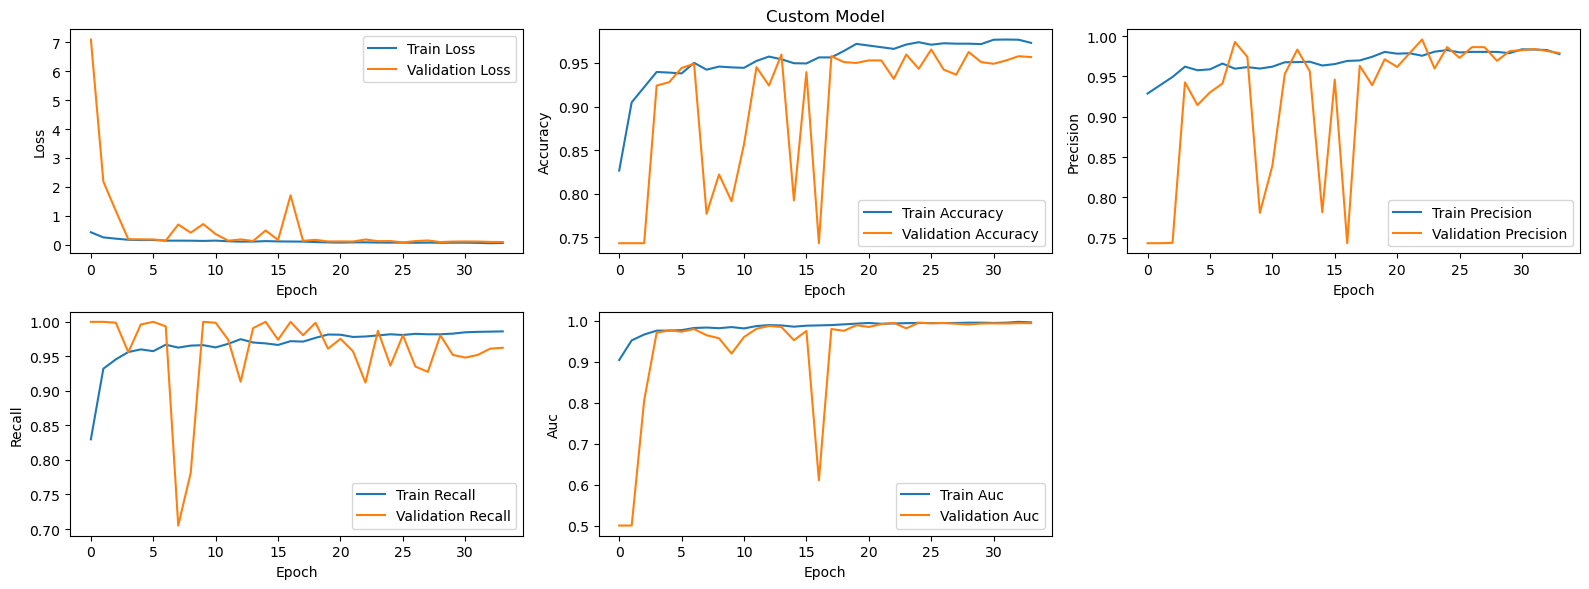

In [59]:

plot_curves(history, 'Custom Model')


20/20 [==============================] - 6s 276ms/step
__Classification Report__ :
              precision    recall  f1-score   support

      Normal       0.97      0.62      0.76       234
   Pneumonia       0.81      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.81      0.83       624
weighted avg       0.87      0.85      0.84       624



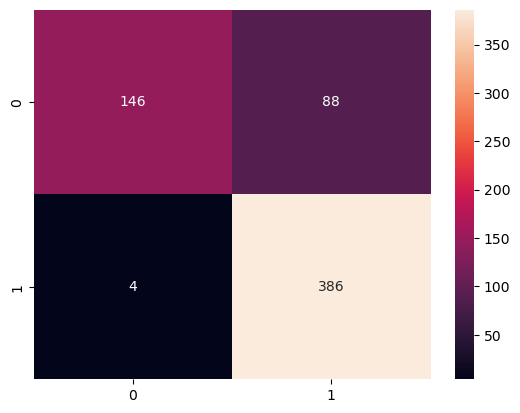

In [63]:
get_evaluation_report(model, test_generator)

# Transfer Learning

### MobileNet

Found 4192 validated image filenames belonging to 2 classes.
Found 1040 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


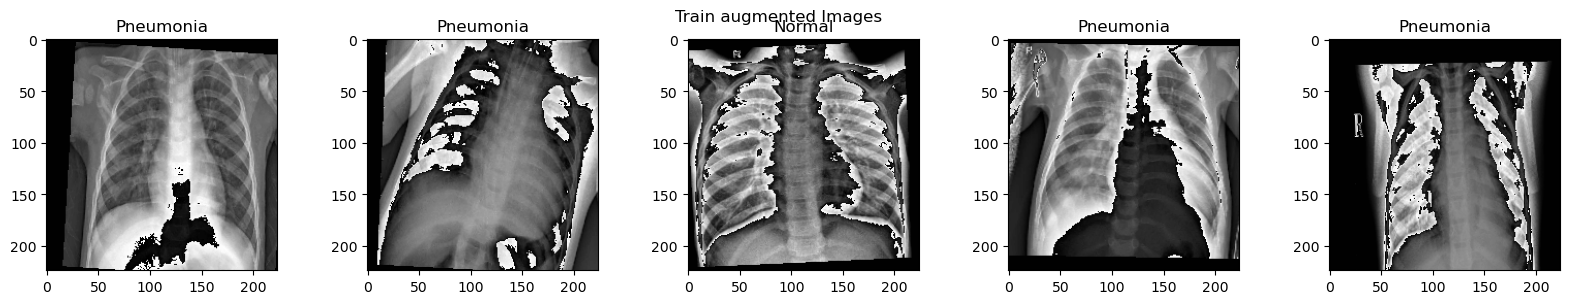

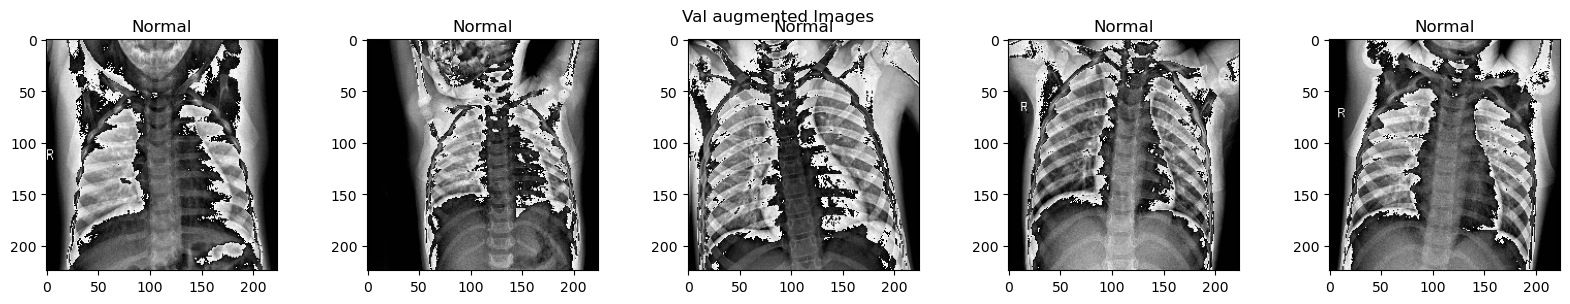

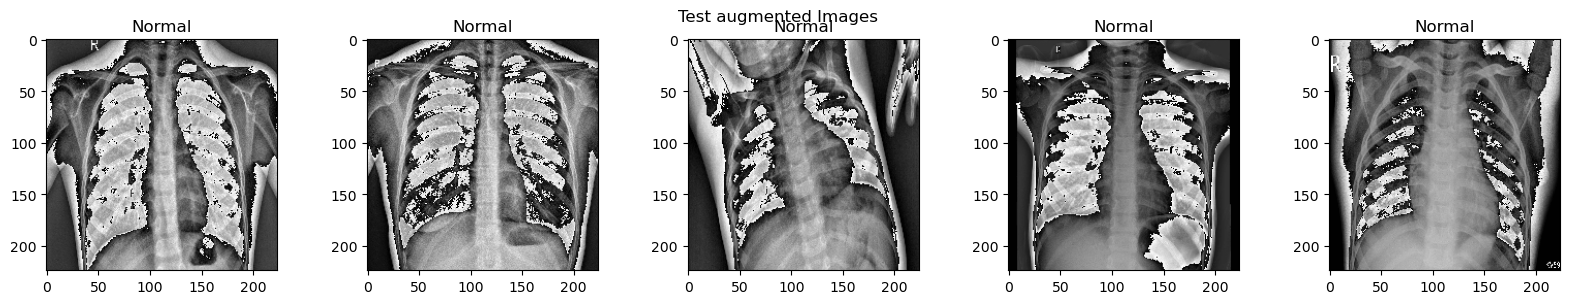

In [67]:
train_generator, val_generator, test_generator = get_image_generators(keras.applications.mobilenet.preprocess_input)

# Reset the generators to avoid issues with plotting
train_generator.reset()
val_generator.reset()
test_generator.reset()

# Plot 5 augmented train images
plot_aug_images(train_generator, "Train augmented Images")
plot_aug_images(val_generator, "Val augmented Images")
plot_aug_images(test_generator, "Test augmented Images")

In [35]:

base_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False 

mob_model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

mob_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 50176)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               12845312  
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,074,433
Trainable params: 12,845,569
Non-trainable params: 3,228,864
__________________________________

In [37]:
mob_history = train_model(mob_model, train_generator, val_generator, './models/mobilenet_model.keras')

Epoch 1/100
131/131 [==============================] - 85s 639ms/step - loss: 0.2000 - accuracy: 0.9468 - precision_4: 0.9652 - recall_4: 0.9630 - auc_4: 0.9765 - val_loss: 0.1109 - val_accuracy: 0.9587 - val_precision_4: 0.9893 - val_recall_4: 0.9547 - val_auc_4: 0.9945 - lr: 0.0010
Epoch 2/100
131/131 [==============================] - 82s 630ms/step - loss: 0.1310 - accuracy: 0.9554 - precision_4: 0.9722 - recall_4: 0.9675 - auc_4: 0.9862 - val_loss: 0.1264 - val_accuracy: 0.9712 - val_precision_4: 0.9720 - val_recall_4: 0.9897 - val_auc_4: 0.9832 - lr: 0.0010
Epoch 3/100
131/131 [==============================] - 82s 623ms/step - loss: 0.1240 - accuracy: 0.9585 - precision_4: 0.9751 - recall_4: 0.9688 - auc_4: 0.9859 - val_loss: 0.0898 - val_accuracy: 0.9731 - val_precision_4: 0.9857 - val_recall_4: 0.9780 - val_auc_4: 0.9937 - lr: 0.0010
Epoch 4/100
131/131 [==============================] - 82s 626ms/step - loss: 0.0937 - accuracy: 0.9680 - precision_4: 0.9794 - recall_4: 0.9775 

In [60]:
# # Load model if reqd
mob_model = tf.keras.models.load_model('./models/mobilenet_model.keras')
mob_model.evaluate(test_generator)

20/20 [==============================] - 6s 233ms/step - loss: 0.5000 - accuracy: 0.8782 - precision_4: 0.8413 - recall_4: 0.9923 - auc_4: 0.9509


[0.5000260472297668,
 0.8782051205635071,
 0.841304361820221,
 0.9923076629638672,
 0.9509095549583435]

In [38]:
mob_model.evaluate(test_generator)

20/20 [==============================] - 5s 243ms/step - loss: 0.5000 - accuracy: 0.8782 - precision_4: 0.8413 - recall_4: 0.9923 - auc_4: 0.9509


[0.5000260472297668,
 0.8782051205635071,
 0.841304361820221,
 0.9923076629638672,
 0.9509095549583435]

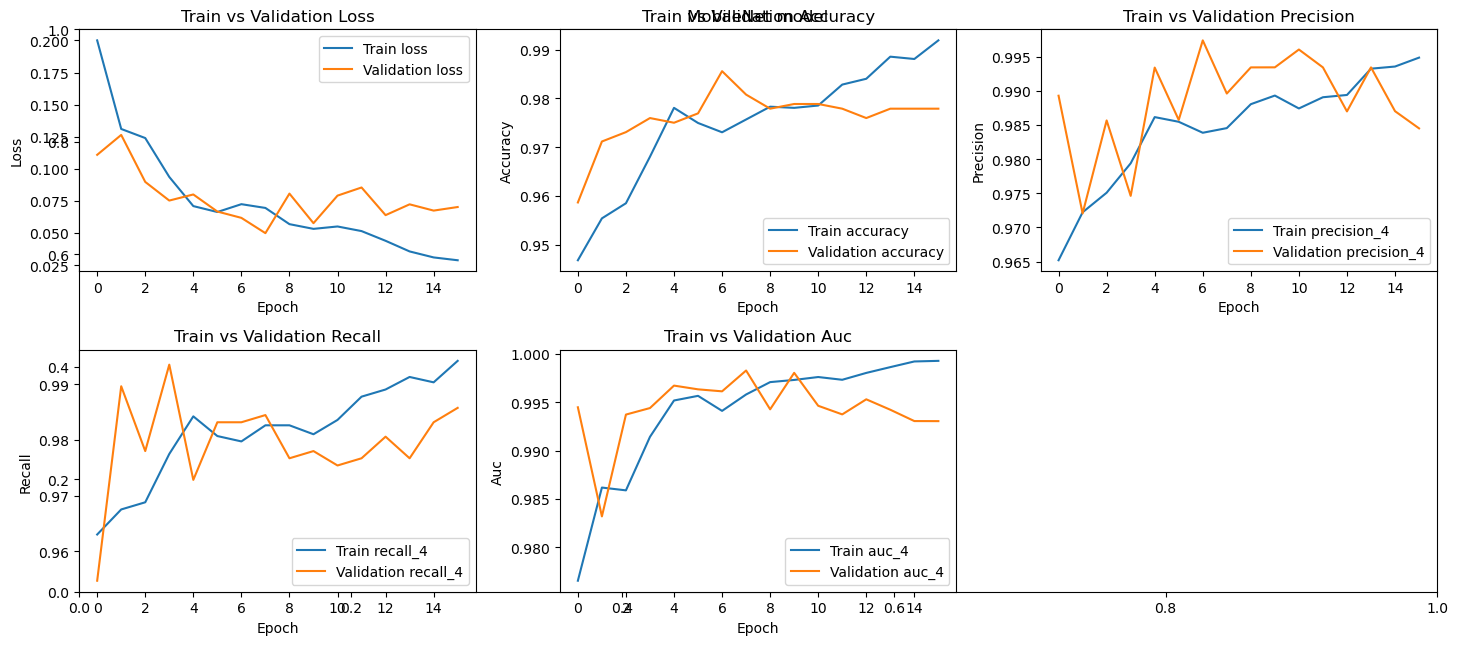

In [39]:
plot_curves(mob_history, 'MobileNet model')

20/20 [==============================] - 5s 247ms/step
__Classification Report__ :
              precision    recall  f1-score   support

      Normal       0.98      0.69      0.81       234
   Pneumonia       0.84      0.99      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.84      0.86       624
weighted avg       0.89      0.88      0.87       624



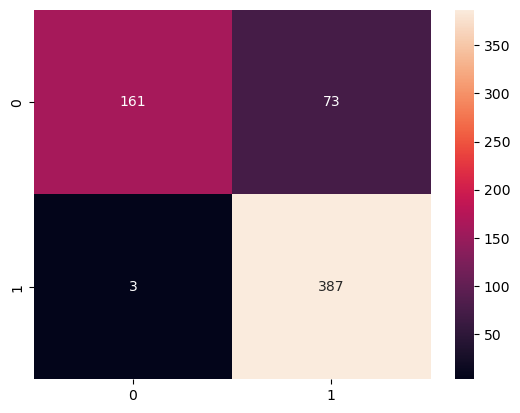

In [68]:
get_evaluation_report(mob_model, test_generator)

## Using VGG-16

In [16]:
import PIL.Image

Found 4192 validated image filenames belonging to 2 classes.
Found 1040 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


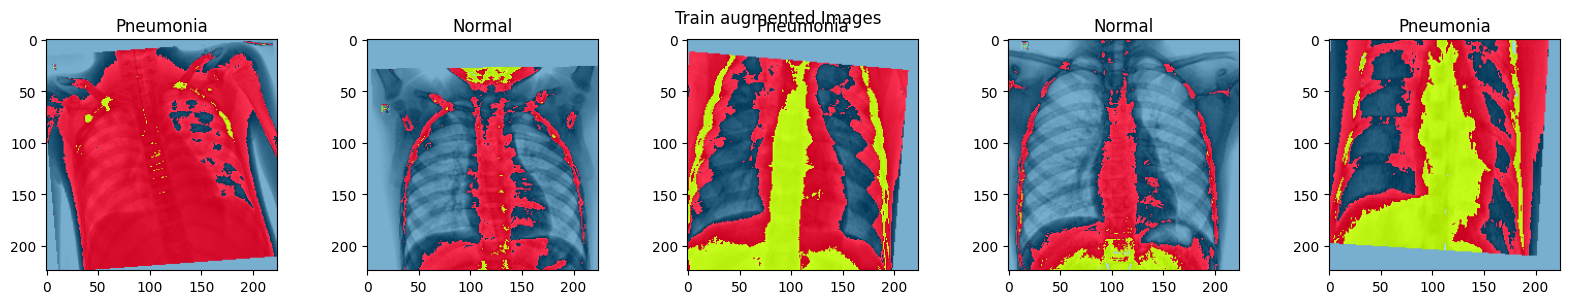

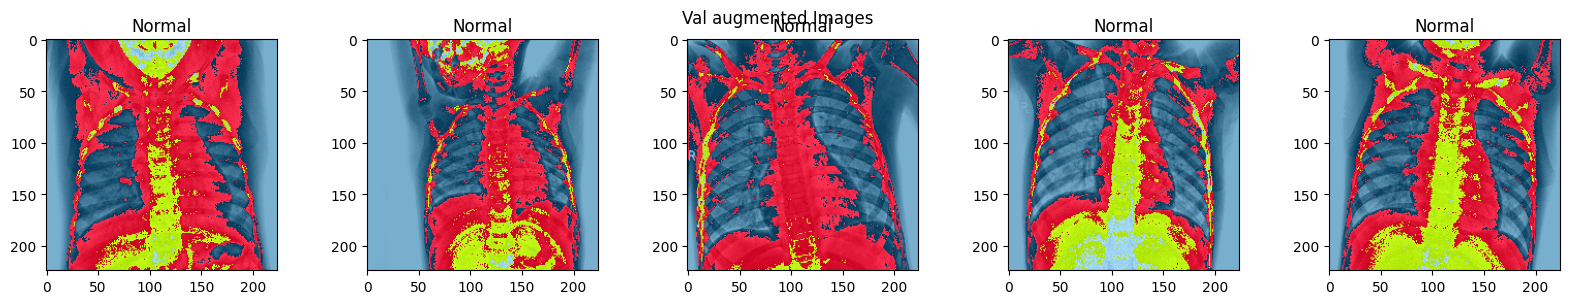

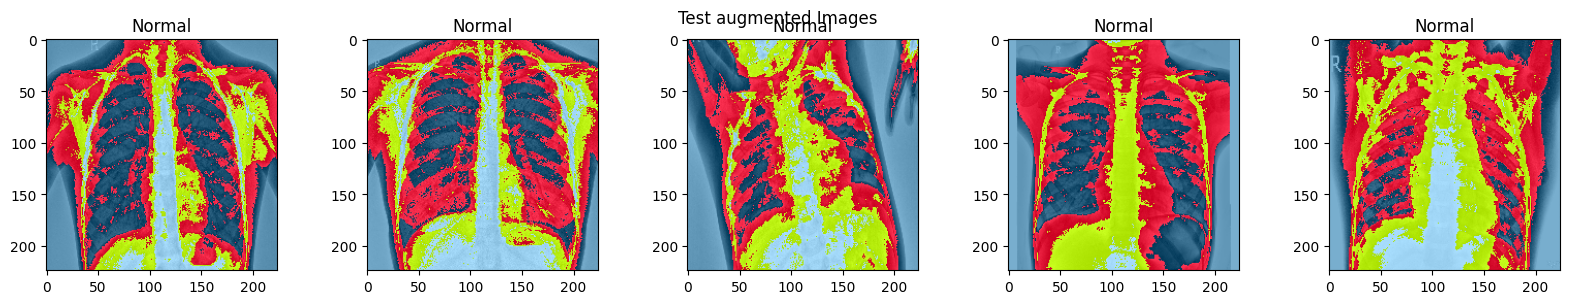

In [17]:
train_generator, val_generator, test_generator = get_image_generators(tf.keras.applications.vgg16.preprocess_input)

# Reset the generators to avoid issues with plotting
train_generator.reset()
val_generator.reset()
test_generator.reset()

# Plot 5 augmented train images
plot_aug_images(train_generator, "Train augmented Images")
plot_aug_images(val_generator, "Val augmented Images")
plot_aug_images(test_generator, "Test augmented Images")


In [21]:
# # Define the model using a pre-trained VGG16 model
# vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# for layer in vgg_model.layers[:15]:
#   layer.trainable = False

# for layer in vgg_model.layers:
#   print(layer.name, "trainable: ", layer.trainable)

input_2 trainable:  False
block1_conv1 trainable:  False
block1_conv2 trainable:  False
block1_pool trainable:  False
block2_conv1 trainable:  False
block2_conv2 trainable:  False
block2_pool trainable:  False
block3_conv1 trainable:  False
block3_conv2 trainable:  False
block3_conv3 trainable:  False
block3_pool trainable:  False
block4_conv1 trainable:  False
block4_conv2 trainable:  False
block4_conv3 trainable:  False
block4_pool trainable:  False
block5_conv1 trainable:  True
block5_conv2 trainable:  True
block5_conv3 trainable:  True
block5_pool trainable:  True


In [42]:
# Define the model using a pre-trained VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

vgg_model.trainable = False

# for layer in vgg_model.layers:
#   print(layer.name, "trainable: ", layer.trainable)

vgg_model = Sequential(
    [
        vgg_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ]
)

# print("\nFinal model summary:")
vgg_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_10 (Dense)            (None, 256)               6422784   
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [43]:
vgg_history = train_model(vgg_model, train_generator, val_generator, './models/vgg_model.keras') 

Epoch 1/100
131/131 [==============================] - 94s 669ms/step - loss: 2.2091 - accuracy: 0.9096 - precision_5: 0.9358 - recall_5: 0.9428 - auc_5: 0.9207 - val_loss: 0.0753 - val_accuracy: 0.9769 - val_precision_5: 0.9934 - val_recall_5: 0.9754 - val_auc_5: 0.9957 - lr: 0.0010
Epoch 2/100
131/131 [==============================] - 84s 637ms/step - loss: 0.1327 - accuracy: 0.9532 - precision_5: 0.9643 - recall_5: 0.9730 - auc_5: 0.9857 - val_loss: 0.0852 - val_accuracy: 0.9712 - val_precision_5: 0.9921 - val_recall_5: 0.9690 - val_auc_5: 0.9957 - lr: 0.0010
Epoch 3/100
131/131 [==============================] - 84s 640ms/step - loss: 0.1313 - accuracy: 0.9542 - precision_5: 0.9644 - recall_5: 0.9743 - auc_5: 0.9861 - val_loss: 0.1009 - val_accuracy: 0.9654 - val_precision_5: 0.9907 - val_recall_5: 0.9625 - val_auc_5: 0.9919 - lr: 0.0010
Epoch 4/100
131/131 [==============================] - 83s 637ms/step - loss: 0.1038 - accuracy: 0.9625 - precision_5: 0.9725 - recall_5: 0.9772 

In [ ]:
import os
os.path.isfile(r'models\vgg_model.keras')

True

In [2]:
# # Load model if reqd
# vgg_model = tf.keras.models.load_model('./models/vgg_model.keras')
# vgg_model.evaluate(test_generator)

In [45]:
# Evaluate the model
print(f'\n Model Evaluation:')
vgg_model.evaluate(test_generator)


 Model Evaluation:
20/20 [==============================] - 6s 256ms/step - loss: 0.3389 - accuracy: 0.9327 - precision_5: 0.9085 - recall_5: 0.9923 - auc_5: 0.9612


[0.33892160654067993,
 0.932692289352417,
 0.908450722694397,
 0.9923076629638672,
 0.9611932635307312]

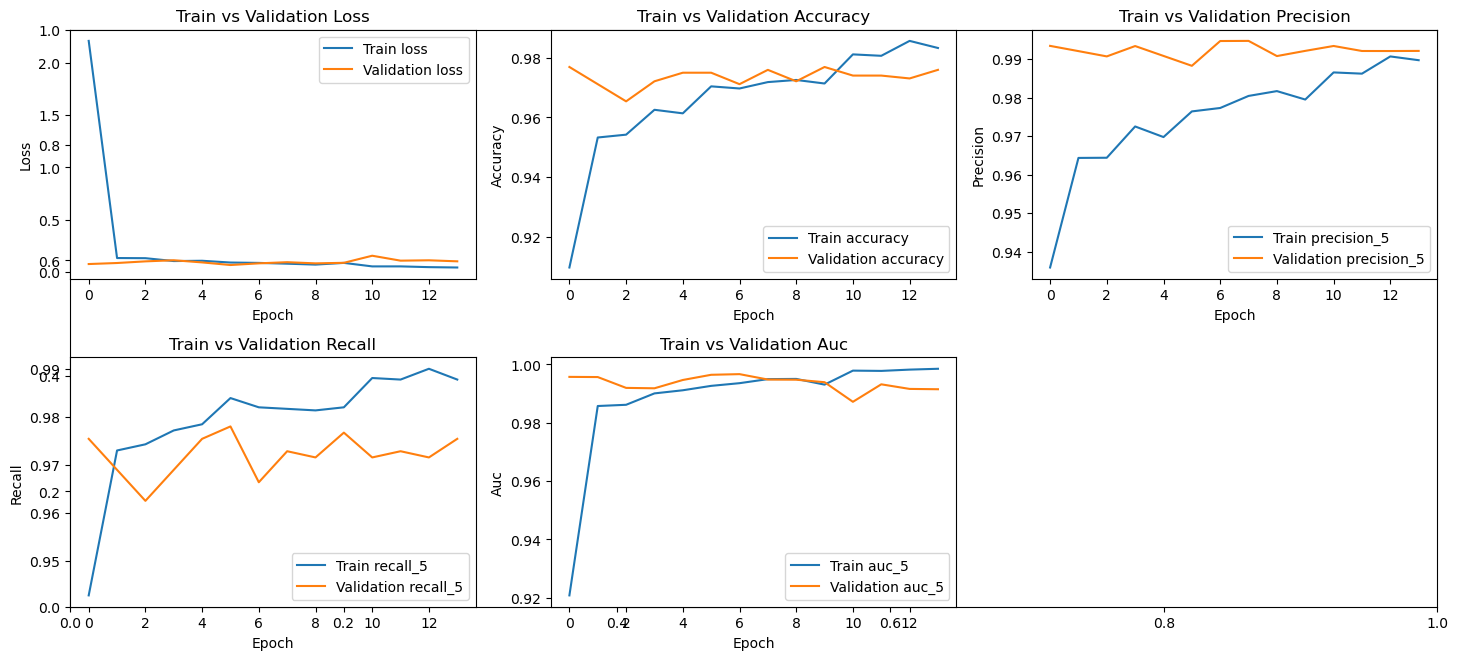

In [46]:
plot_curves(vgg_history)

In [37]:
tf.__version__

'2.16.1'

20/20 [==============================] - 6s 254ms/step
__Classification Report__ :
              precision    recall  f1-score   support

      Normal       0.98      0.83      0.90       234
   Pneumonia       0.91      0.99      0.95       390

    accuracy                           0.93       624
   macro avg       0.95      0.91      0.93       624
weighted avg       0.94      0.93      0.93       624



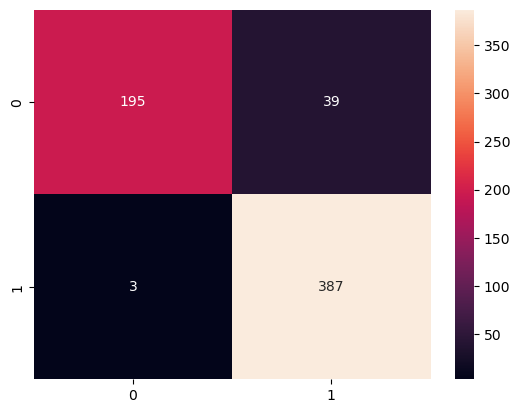

In [47]:
get_evaluation_report(vgg_model, test_generator)

## ResNet50 V2

Found 4192 validated image filenames belonging to 2 classes.
Found 1040 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


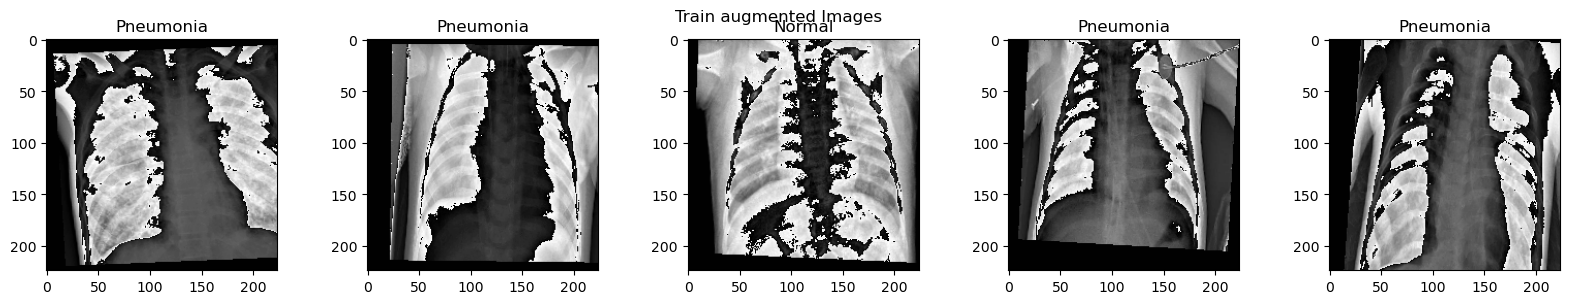

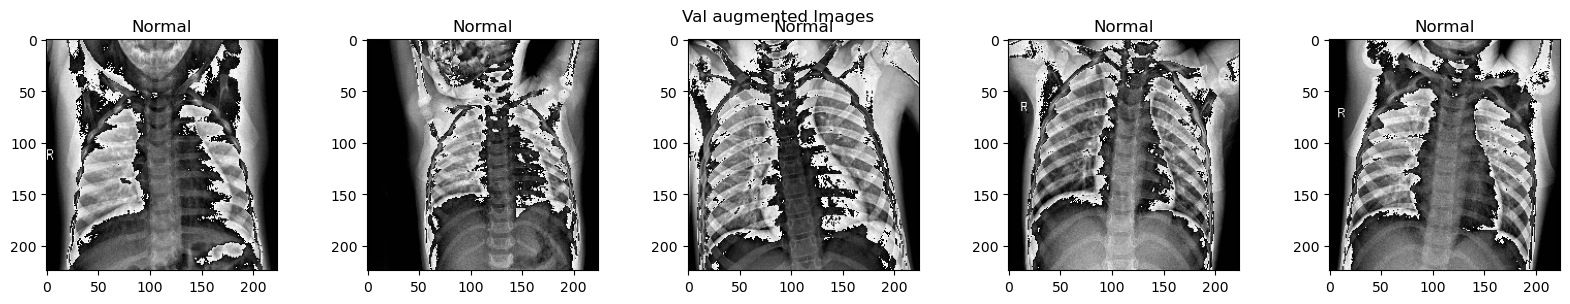

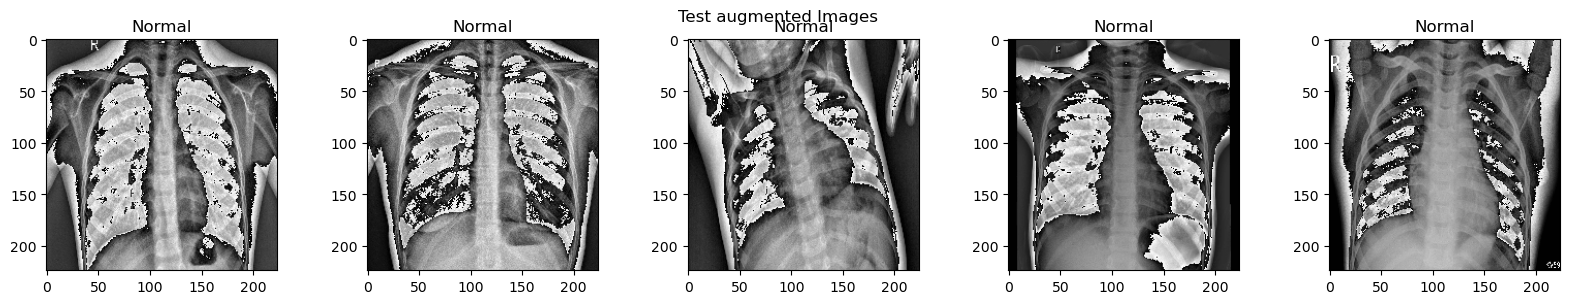

In [48]:
train_generator, val_generator, test_generator = get_image_generators(keras.applications.resnet_v2.preprocess_input)

# Reset the generators to avoid issues with plotting
train_generator.reset()
val_generator.reset()
test_generator.reset()

# Plot 5 augmented train images
plot_aug_images(train_generator, "Train augmented Images")
plot_aug_images(val_generator, "Val augmented Images")
plot_aug_images(test_generator, "Test augmented Images")

In [49]:
# Define the model using a pre-trained VGG16 model
resnet_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

resnet_model.trainable = False

# for layer in resnet_model.layers:
#   print(layer.name, "trainable: ", layer.trainable)

resnet_model = Sequential(
    [
        resnet_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ]
)

resnet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten_6 (Flatten)         (None, 100352)            0         
                                                                 
 dense_12 (Dense)            (None, 256)               25690368  
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 49,255,425
Trainable params: 25,690,625
Non-trainable params: 23,564,800
_________________________________________________________________


In [50]:
resnet_history = train_model(resnet_model, train_generator, val_generator, './models/resnet50v2_model.keras')

Epoch 1/100
131/131 [==============================] - 89s 647ms/step - loss: 2.3982 - accuracy: 0.8838 - precision_6: 0.9092 - recall_6: 0.9370 - auc_6: 0.9076 - val_loss: 0.0967 - val_accuracy: 0.9625 - val_precision_6: 0.9742 - val_recall_6: 0.9754 - val_auc_6: 0.9928 - lr: 0.0010
Epoch 2/100
131/131 [==============================] - 83s 630ms/step - loss: 0.1579 - accuracy: 0.9463 - precision_6: 0.9538 - recall_6: 0.9749 - auc_6: 0.9837 - val_loss: 0.1081 - val_accuracy: 0.9587 - val_precision_6: 0.9728 - val_recall_6: 0.9715 - val_auc_6: 0.9914 - lr: 0.0010
Epoch 3/100
131/131 [==============================] - 82s 623ms/step - loss: 0.1325 - accuracy: 0.9597 - precision_6: 0.9637 - recall_6: 0.9826 - auc_6: 0.9907 - val_loss: 0.1109 - val_accuracy: 0.9606 - val_precision_6: 0.9828 - val_recall_6: 0.9638 - val_auc_6: 0.9927 - lr: 0.0010
Epoch 4/100
131/131 [==============================] - 81s 620ms/step - loss: 0.1261 - accuracy: 0.9597 - precision_6: 0.9685 - recall_6: 0.9775 

In [56]:
# # Load model if reqd
# resnet_model = tf.keras.models.load_model('./models/resnet50v2_model.keras')
# resnet_model.evaluate(test_generator)

20/20 [==============================] - 7s 253ms/step - loss: 0.3399 - accuracy: 0.8686 - precision_6: 0.8407 - recall_6: 0.9744 - auc_6: 0.9603


[0.33987706899642944,
 0.8685897588729858,
 0.8407079577445984,
 0.9743589758872986,
 0.960278332233429]

In [52]:
# Evaluate the model
print(f'\n Model Evaluation:')
resnet_model.evaluate(test_generator)


 Model Evaluation:
20/20 [==============================] - 5s 237ms/step - loss: 0.3399 - accuracy: 0.8686 - precision_6: 0.8407 - recall_6: 0.9744 - auc_6: 0.9603


[0.33987706899642944,
 0.8685897588729858,
 0.8407079577445984,
 0.9743589758872986,
 0.960278332233429]

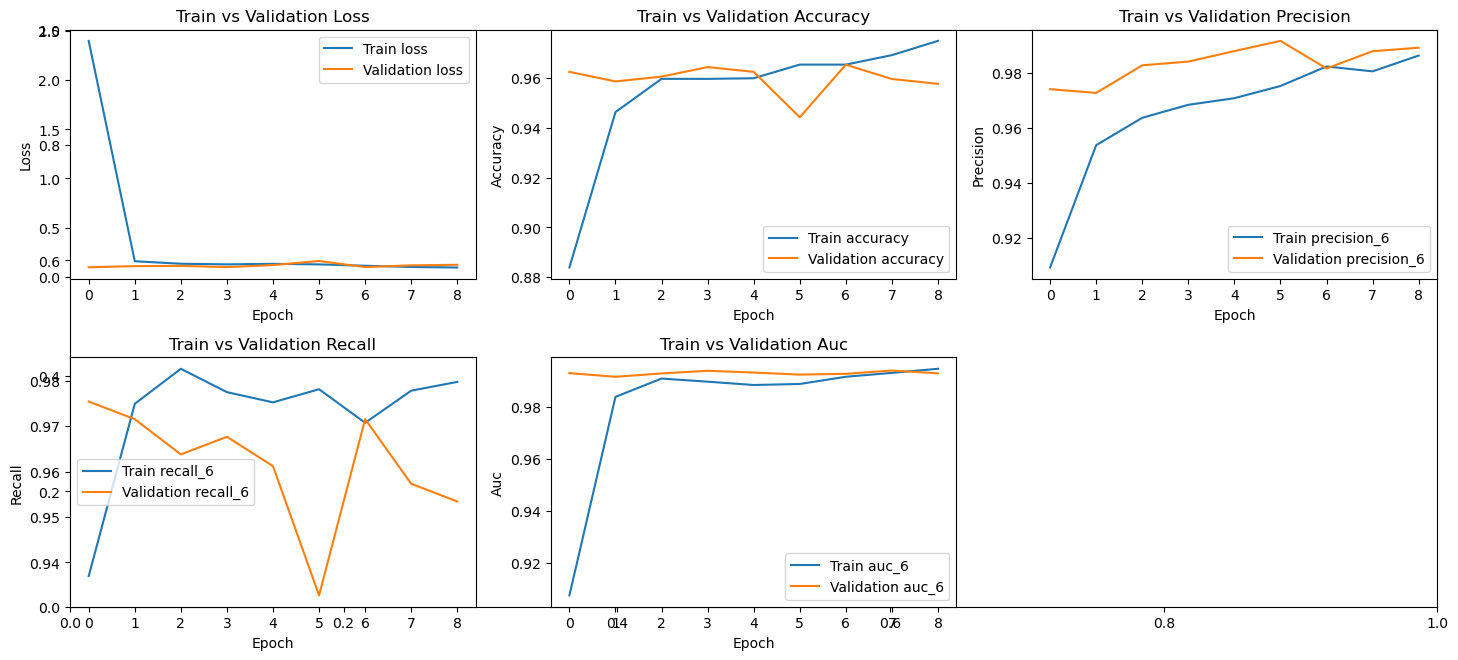

In [53]:
plot_curves(resnet_history)

20/20 [==============================] - 6s 242ms/step
__Classification Report__ :
              precision    recall  f1-score   support

      Normal       0.94      0.69      0.80       234
   Pneumonia       0.84      0.97      0.90       390

    accuracy                           0.87       624
   macro avg       0.89      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



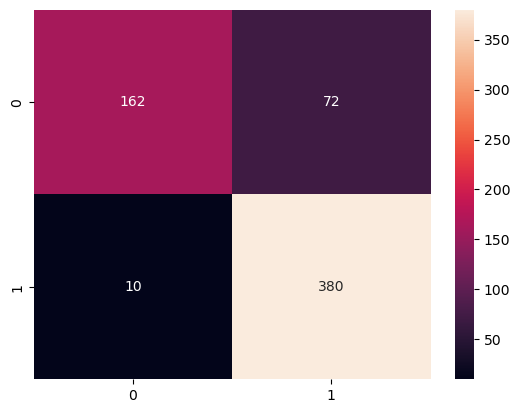

In [54]:
get_evaluation_report(resnet_model, test_generator)

## Xception

Found 4192 validated image filenames belonging to 2 classes.
Found 1040 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


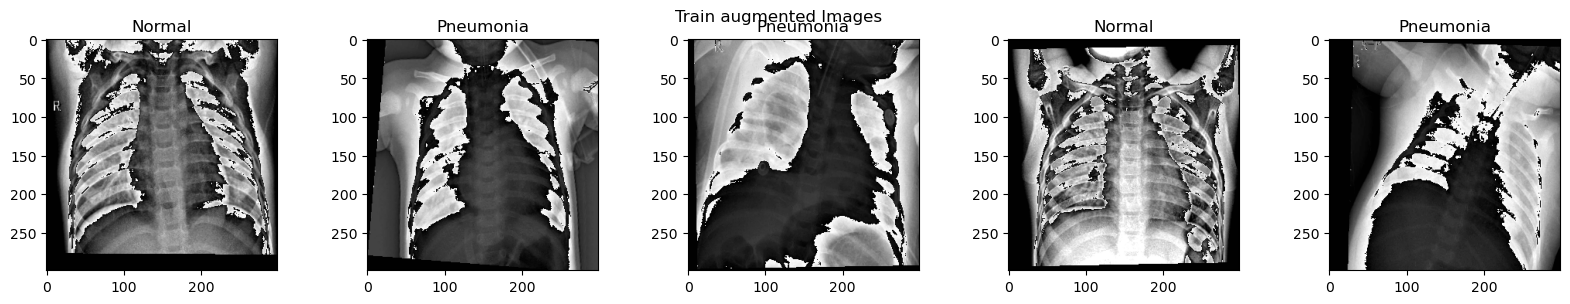

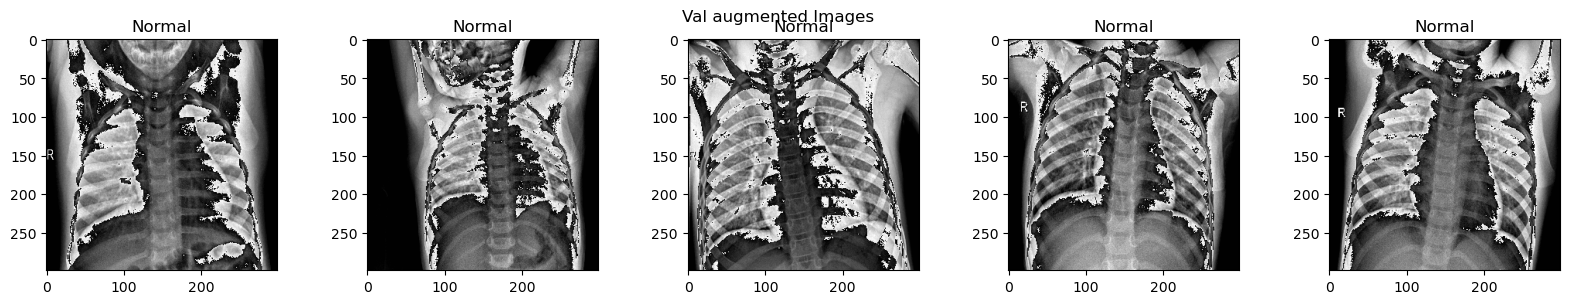

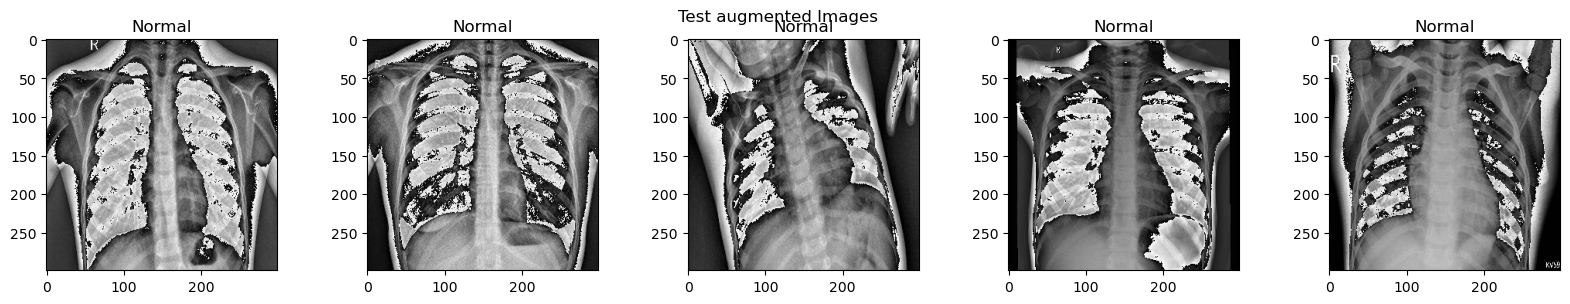

In [16]:
train_generator, val_generator, test_generator = get_image_generators(keras.applications.xception.preprocess_input, target_size=(299,299))

# Reset the generators to avoid issues with plotting
train_generator.reset()
val_generator.reset()
test_generator.reset()

# Plot 5 augmented train images
plot_aug_images(train_generator, "Train augmented Images")
plot_aug_images(val_generator, "Val augmented Images")
plot_aug_images(test_generator, "Test augmented Images")

In [18]:
# Define the model using a pre-trained VGG16 model
xcep_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

xcep_model.trainable = False

# for layer in xcep_model.layers:
#   print(layer.name, "trainable: ", layer.trainable)

xcep_model = Sequential(
    [
        xcep_model,
        Flatten(),
        Dense(256, activation='relu'),
        # BatchNormalization(),  # Adding batch normalization
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ]
)

print("\nFinal model summary:")
xcep_model.summary()


Final model summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten_1 (Flatten)         (None, 204800)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               52429056  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 73,290,793
Trainable params: 52,429,313
Non-trainable params: 20,861,480
_________________________________________________________________


In [19]:
xception_history = train_model(xcep_model, train_generator, val_generator, './models/xception_model.keras')

Epoch 1/100
131/131 [==============================] - 123s 898ms/step - loss: 1.3763 - accuracy: 0.9165 - precision: 0.9426 - recall: 0.9450 - auc: 0.9352 - val_loss: 0.0990 - val_accuracy: 0.9644 - val_precision: 0.9817 - val_recall: 0.9702 - val_auc: 0.9921 - lr: 0.0010
Epoch 2/100
131/131 [==============================] - 114s 865ms/step - loss: 0.1363 - accuracy: 0.9454 - precision: 0.9598 - recall: 0.9669 - auc: 0.9854 - val_loss: 0.1657 - val_accuracy: 0.9452 - val_precision: 0.9945 - val_recall: 0.9314 - val_auc: 0.9900 - lr: 0.0010
Epoch 3/100
131/131 [==============================] - 114s 867ms/step - loss: 0.1426 - accuracy: 0.9482 - precision: 0.9585 - recall: 0.9723 - auc: 0.9844 - val_loss: 0.1126 - val_accuracy: 0.9548 - val_precision: 0.9932 - val_recall: 0.9457 - val_auc: 0.9917 - lr: 0.0010
Epoch 4/100
131/131 [==============================] - 115s 875ms/step - loss: 0.1244 - accuracy: 0.9535 - precision: 0.9652 - recall: 0.9723 - auc: 0.9881 - val_loss: 0.1260 - v

In [1]:
# # Load model if reqd
# xcep_model = tf.keras.models.load_model('./models/xception_model_87.keras')
# xcep_model.evaluate(test_generator)

In [20]:
# Evaluate the model
print(f'\n Model Evaluation:')
xcep_model.evaluate(test_generator)


 Model Evaluation:
20/20 [==============================] - 6s 281ms/step - loss: 0.3953 - accuracy: 0.8942 - precision: 0.8682 - recall: 0.9795 - auc: 0.9552


[0.39525896310806274,
 0.8942307829856873,
 0.8681818246841431,
 0.9794871807098389,
 0.9551610946655273]

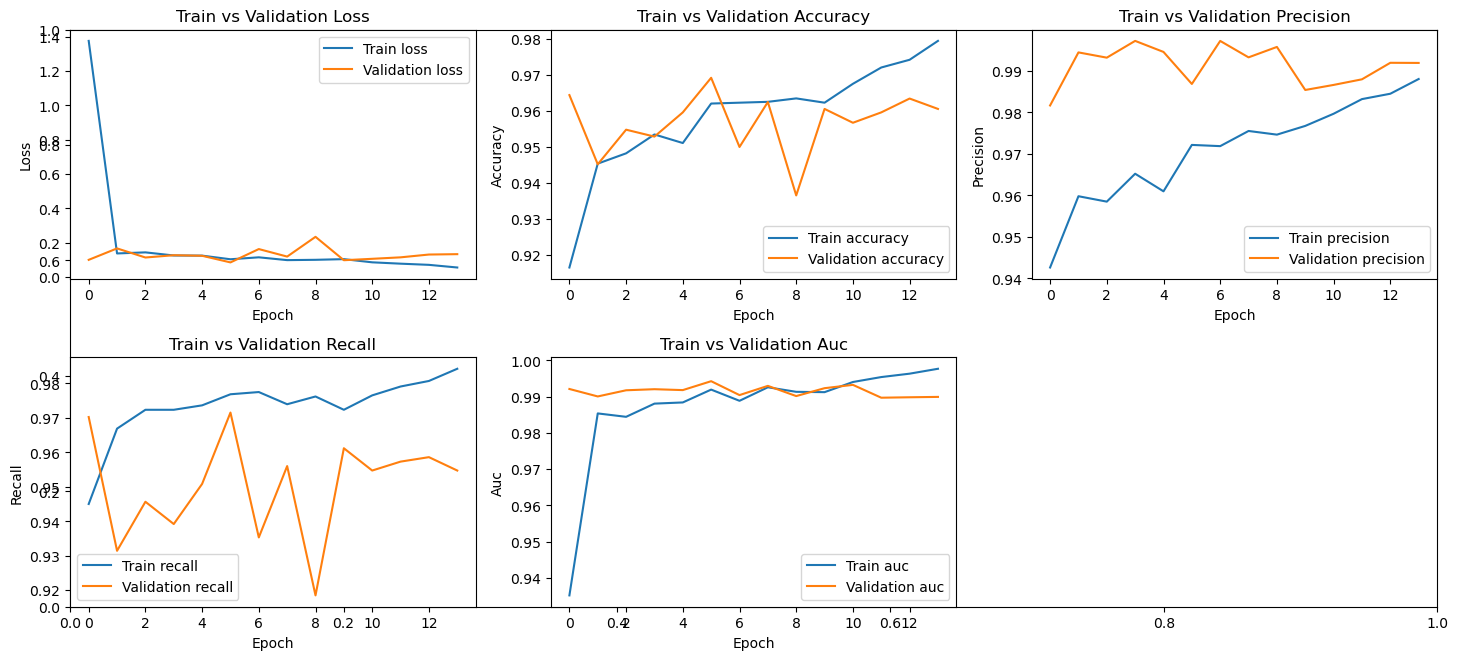

In [21]:
plot_curves(xception_history)

20/20 [==============================] - 7s 283ms/step
__Classification Report__ :
              precision    recall  f1-score   support

      Normal       0.96      0.75      0.84       234
   Pneumonia       0.87      0.98      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.87      0.88       624
weighted avg       0.90      0.89      0.89       624



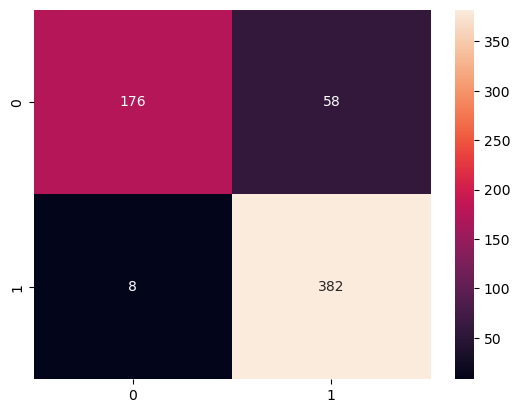

In [22]:
get_evaluation_report(xcep_model, test_generator)

In [71]:
# TODO: 
# https://www.analyticsvidhya.com/blog/2020/09/pneumonia-detection-using-cnn-with-implementation-in-python/ for multiclass classification 
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10416977/